In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.6 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import os
import joblib
import keras_tuner as kt

In [3]:
LAT_TARGET = -6.2
LON_TARGET = 106.8
START_YEAR = 2019
END_YEAR = 2024

PARAMS = [
    "T2M",
    "T2M_MIN",
    "T2M_MAX",
    "RH2M",
    "WS10M",
    "WD10M",
    "PS",
    "PRECTOTCORR",
    "ALLSKY_SFC_SW_DWN",
    "ALLSKY_SFC_UVA"
]

def fetch_nasa_power(lat, lon, start_yyyymmdd, end_yyyymmdd, params=PARAMS):
    params_str = ",".join(params)
    url = (
        "https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"parameters={params_str}&community=RE"
        f"&latitude={lat}&longitude={lon}"
        f"&start={start_yyyymmdd}&end={end_yyyymmdd}&format=JSON"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()
    raw = data["properties"]["parameter"]
    dates = sorted(raw[params[0]].keys())
    rows = []
    for d in dates:
        row = {"date": datetime.strptime(d, "%Y%m%d")}
        for p in params:
            row[p] = raw.get(p, {}).get(d, np.nan)
        rows.append(row)
    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return df

In [4]:
start = int(f"{START_YEAR}0101")
end   = int(f"{END_YEAR}1231")
print("Fetching target sample (Jakarta) ...")
df_target = fetch_nasa_power(LAT_TARGET, LON_TARGET, start, end)
print(f"Target data shape: {df_target.shape}")
df_target.head()

Fetching target sample (Jakarta) ...
Target data shape: (2192, 11)


,date,T2M,T2M_MIN,T2M_MAX,RH2M,WS10M,WD10M,PS,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_UVA
0,2019-01-01,26.93,25.49,28.45,86.39,5.34,258.4,100.91,18.66,3.3686,0.2446
1,2019-01-02,27.25,25.21,30.06,83.16,5.78,255.7,100.92,24.26,5.1014,0.3372
2,2019-01-03,27.56,25.28,30.55,80.62,5.73,242.6,100.98,5.69,5.4434,0.3516
3,2019-01-04,27.83,25.05,31.21,77.58,4.30,242.6,100.96,0.41,6.4493,0.3967
4,2019-01-05,27.86,25.18,30.91,76.10,2.59,260.0,100.95,1.87,5.6306,0.3478


In [5]:
lat_list = [LAT_TARGET + d for d in [-0.5, -0.25, 0.0, 0.25, 0.5]]
lon_list = [LON_TARGET + d for d in [-0.5, -0.25, 0.0, 0.25, 0.5]]

print("Fetching multi-location data for pretraining...")
corpus_dfs = {}
for la in lat_list:
    for lo in lon_list:
        key = f"{la:.2f}_{lo:.2f}"
        try:
            df = fetch_nasa_power(la, lo, start, end)
            df = df.dropna(thresh=int(len(PARAMS)*0.6)).reset_index(drop=True)
            corpus_dfs[key] = df
            print(f"-> {key}: {len(df)} rows")
        except Exception as e:
            print(f"Failed for {key}: {e}")

print(f"\nTotal locations fetched: {len(corpus_dfs)}")

Fetching multi-location data for pretraining...
-> -6.70_106.30: 2192 rows
-> -6.70_106.55: 2192 rows
-> -6.70_106.80: 2192 rows
-> -6.70_107.05: 2192 rows
-> -6.70_107.30: 2192 rows
-> -6.45_106.30: 2192 rows
-> -6.45_106.55: 2192 rows
-> -6.45_106.80: 2192 rows
-> -6.45_107.05: 2192 rows
-> -6.45_107.30: 2192 rows
-> -6.20_106.30: 2192 rows
-> -6.20_106.55: 2192 rows
-> -6.20_106.80: 2192 rows
-> -6.20_107.05: 2192 rows
-> -6.20_107.30: 2192 rows
-> -5.95_106.30: 2192 rows
-> -5.95_106.55: 2192 rows
-> -5.95_106.80: 2192 rows
-> -5.95_107.05: 2192 rows
-> -5.95_107.30: 2192 rows
-> -5.70_106.30: 2192 rows
-> -5.70_106.55: 2192 rows
-> -5.70_106.80: 2192 rows
-> -5.70_107.05: 2192 rows
-> -5.70_107.30: 2192 rows

Total locations fetched: 25


In [6]:
series_list = []
dates_ref = pd.date_range(start=f"{START_YEAR}-01-01", end=f"{END_YEAR}-12-31", freq='D')

for key, df in corpus_dfs.items():
    df2 = df.set_index("date").reindex(dates_ref).interpolate().ffill().bfill().reset_index()
    if "PS" in df2.columns:
        df2["PS"] = df2["PS"] / 100.0
    df2 = df2[["index"] + PARAMS].rename(columns={"index":"date"})
    series_list.append(df2[PARAMS].values.astype(np.float32))

X_corpus = np.stack(series_list, axis=0)
print(f"Corpus shape (n_series, timesteps, features): {X_corpus.shape}")

n_series, timesteps, n_features = X_corpus.shape
flat = X_corpus.reshape(-1, n_features)
scaler = MinMaxScaler()
flat_scaled = scaler.fit_transform(flat)
X_corpus_scaled = flat_scaled.reshape(n_series, timesteps, n_features)

joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved to scaler.joblib")

Corpus shape (n_series, timesteps, features): (25, 2192, 10)
Scaler saved to scaler.joblib


In [7]:
WINDOW = 14
X_pre = []
y_pre = []

for s in range(n_series):
    arr = X_corpus_scaled[s]
    for i in range(WINDOW, arr.shape[0]):
        X_pre.append(arr[i-WINDOW:i])
        y_pre.append(arr[i, 0])

X_pre = np.array(X_pre)
y_pre = np.array(y_pre)
print(f"Pretrain samples: X={X_pre.shape}, y={y_pre.shape}")

split_idx = int(0.9 * X_pre.shape[0])
X_pre_train, X_pre_val = X_pre[:split_idx], X_pre[split_idx:]
y_pre_train, y_pre_val = y_pre[:split_idx], y_pre[split_idx:]

Pretrain samples: X=(54450, 14, 10), y=(54450,)


In [8]:
def build_lstm_encoder(window=WINDOW, n_features=n_features, latent_dim=128):
    """LSTM-based encoder untuk transfer learning"""
    inp = layers.Input(shape=(window, n_features))
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(latent_dim, activation='relu')(x)
    model = models.Model(inputs=inp, outputs=x, name="lstm_encoder")
    return model

encoder = build_lstm_encoder()
encoder.summary()

Model: "lstm_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 14, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,896 (503.50 KB)

 Trainable params: 128,896 (503.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
inp = layers.Input(shape=(WINDOW, n_features))
embed = encoder(inp)
out = layers.Dense(64, activation='relu')(embed)
out = layers.Dropout(0.2)(out)
out = layers.Dense(1, activation='linear')(out)

pretrain_model = models.Model(inputs=inp, outputs=out)
pretrain_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)
pretrain_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_encoder (Functional)       │ (None, 128)            │       128,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,217 (536.00 KB)

 Trainable params: 137,217 (536.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - loss: 0.0195 - mae: 0.0956 - val_loss: 0.0022 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 0.0061 - mae: 0.0615 - val_loss: 0.0020 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - loss: 0.0054 - mae: 0.0578 - val_loss: 0.0018 - val_mae: 0.0333 - learning_rate: 0.0010
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 0.0047 - mae: 0.0540 - val_loss: 0.0017 - val_mae: 0.0321 - learning_rate: 0.0010
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - loss: 0.0039 - mae: 0.0492 - val_loss: 0.0016 - val_mae: 0.0318 - learning_rate: 0.0010
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.0035 - mae: 0.0466 - val_loss: 0.0016 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 0.0032 - mae: 0.0447 - val_loss: 0.0019 - val_mae: 0.0347 - learning_rate:

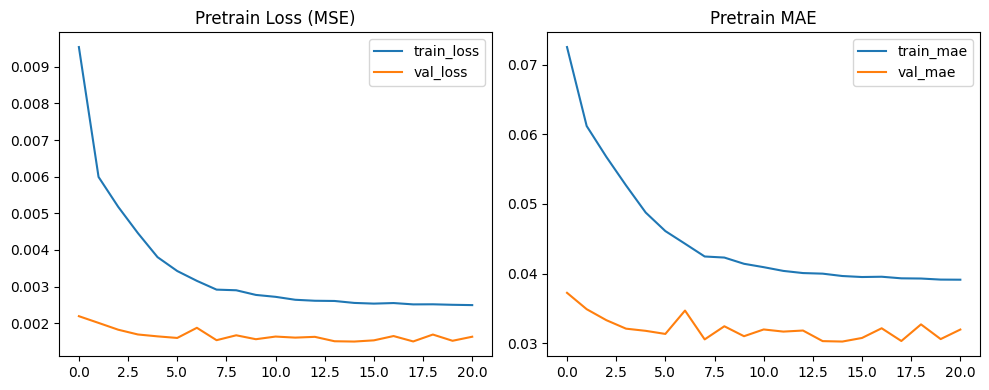

In [11]:
EPOCHS_PRE = 30
BATCH = 128

es_pre = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history_pre = pretrain_model.fit(
    X_pre_train, y_pre_train,
    validation_data=(X_pre_val, y_pre_val),
    epochs=EPOCHS_PRE,
    batch_size=BATCH,
    callbacks=[es_pre, reduce_lr],
    verbose=1
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_pre.history['loss'], label='train_loss')
plt.plot(history_pre.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Pretrain Loss (MSE)")
plt.subplot(1,2,2)
plt.plot(history_pre.history['mae'], label='train_mae')
plt.plot(history_pre.history['val_mae'], label='val_mae')
plt.legend(); plt.title("Pretrain MAE")
plt.tight_layout()
plt.show()

In [12]:
ENCODER_WEIGHTS = "encoder_lstm_pretrained.weights.h5"
encoder.save_weights(ENCODER_WEIGHTS)
print(f"Saved encoder weights to {ENCODER_WEIGHTS}")

Saved encoder weights to encoder_lstm_pretrained.weights.h5


In [13]:
df_target_full = fetch_nasa_power(LAT_TARGET, LON_TARGET, start, end)
if "PS" in df_target_full.columns:
    df_target_full["PS"] = df_target_full["PS"] / 100.0

df_target_full = df_target_full.set_index("date").reindex(dates_ref).interpolate().ffill().bfill().reset_index()
target_arr = df_target_full[PARAMS].values.astype(np.float32)

flat_target = target_arr.reshape(-1, n_features)
flat_target_scaled = scaler.transform(flat_target)
target_scaled = flat_target_scaled.reshape(-1, n_features)

WINDOW_FINE = WINDOW
X_tgt, y_tgt = [], []
for i in range(WINDOW_FINE, target_scaled.shape[0]):
    X_tgt.append(target_scaled[i-WINDOW_FINE:i])
    y_tgt.append(target_scaled[i, 0])

X_tgt = np.array(X_tgt)
y_tgt = np.array(y_tgt)

split_idx = int(0.8 * len(X_tgt))
X_train_tgt, X_test_tgt = X_tgt[:split_idx], X_tgt[split_idx:]
y_train_tgt, y_test_tgt = y_tgt[:split_idx], y_tgt[split_idx:]

print(f"Target training: {X_train_tgt.shape}, {y_train_tgt.shape}")
print(f"Target testing: {X_test_tgt.shape}, {y_test_tgt.shape}")

Target training: (1742, 14, 10), (1742,)
Target testing: (436, 14, 10), (436,)


In [14]:
def build_transfer_model(hp):
    """Model builder untuk hyperparameter tuning"""
    encoder_t = build_lstm_encoder(window=WINDOW_FINE, n_features=n_features, latent_dim=128)
    encoder_t.load_weights(ENCODER_WEIGHTS)

    for layer in encoder_t.layers:
        layer.trainable = False

    inp = layers.Input(shape=(WINDOW_FINE, n_features))
    emb = encoder_t(inp)

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    x = layers.RepeatVector(1)(emb)
    x = layers.LSTM(lstm_units, return_sequences=False)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model

In [15]:
tuner = kt.Hyperband(
    build_transfer_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='tuning_results',
    project_name='lstm_transfer'
)

stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Starting hyperparameter search...")
tuner.search(
    X_train_tgt, y_train_tgt,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest hyperparameters:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 90 Complete [00h 00m 45s]
val_loss: 0.0018998879240825772

Best val_loss So Far: 0.0015830370830371976
Total elapsed time: 00h 21m 51s

Best hyperparameters:
LSTM units: 96
Dense units: 48
Dropout rate: 0.1
Learning rate: 0.001


In [16]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 14, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_encoder (Functional)       │ (None, 128)            │       128,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,001 (859.38 KB)

 Trainable params: 91,105 (355.88 KB)

 Non-trainable params: 128,896 (503.50 KB)

In [17]:
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

print("Performing Time Series Cross Validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_tgt)):
    print(f"\nFold {fold + 1}/5")

    X_fold_train, X_fold_val = X_train_tgt[train_idx], X_train_tgt[val_idx]
    y_fold_train, y_fold_val = y_train_tgt[train_idx], y_train_tgt[val_idx]

    fold_model = tuner.hypermodel.build(best_hps)

    fold_model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=20,
        batch_size=32,
        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        verbose=0
    )

    fold_pred = fold_model.predict(X_fold_val, verbose=0)
    fold_mse = mean_squared_error(y_fold_val, fold_pred)
    cv_scores.append(fold_mse)
    print(f"Fold {fold + 1} MSE: {fold_mse:.6f}")

print(f"\nCross-validation MSE: {np.mean(cv_scores):.6f} (+/- {np.std(cv_scores):.6f})")

Performing Time Series Cross Validation...

Fold 1/5
Fold 1 MSE: 0.002049

Fold 2/5
Fold 2 MSE: 0.002106

Fold 3/5
Fold 3 MSE: 0.001925

Fold 4/5
Fold 4 MSE: 0.001640

Fold 5/5
Fold 5 MSE: 0.001719

Cross-validation MSE: 0.001888 (+/- 0.000182)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2754 - mae: 0.4966 - val_loss: 0.0142 - val_mae: 0.0991 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - mae: 0.0623 - val_loss: 0.0023 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - mae: 0.0411 - val_loss: 0.0019 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0025 - mae: 0.0394 - val_loss: 0.0018 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0024 - mae: 0.0387 - val_loss: 0.0018 - val_mae: 0.0339 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - mae: 0.0369 - val_loss: 0.0017 - val_mae: 0.0335 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - mae: 0.0374 - val_loss: 0.0018 - val_mae: 0.0346 - learning_rate: 0.0010
Epoch 8/50
47

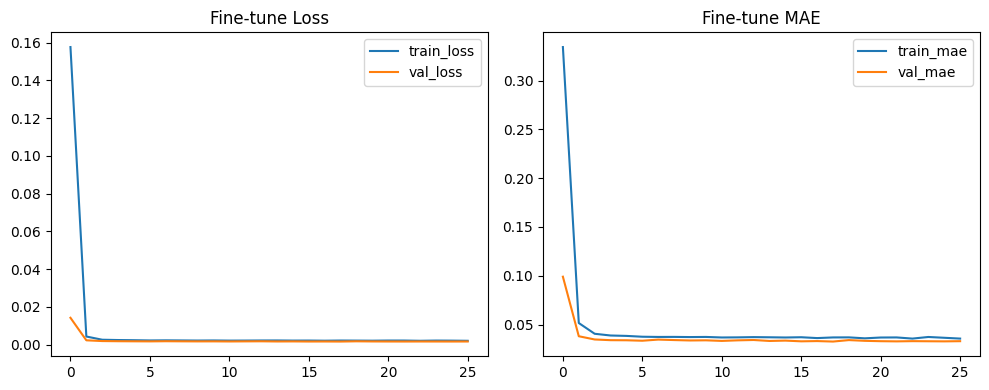

In [18]:
EPOCHS_FINE = 50
BATCH_FINE = 32

es_fine = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
reduce_lr_fine = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7
)

history_fine = best_model.fit(
    X_train_tgt, y_train_tgt,
    validation_split=0.15,
    epochs=EPOCHS_FINE,
    batch_size=BATCH_FINE,
    callbacks=[es_fine, reduce_lr_fine],
    verbose=1
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Fine-tune Loss")
plt.subplot(1,2,2)
plt.plot(history_fine.history['mae'], label='train_mae')
plt.plot(history_fine.history['val_mae'], label='val_mae')
plt.legend(); plt.title("Fine-tune MAE")
plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
=== Transfer Learning Evaluation (Jakarta) ===
MSE: 0.1268
RMSE: 0.3561
MAE: 0.2758
MAPE: 0.98%


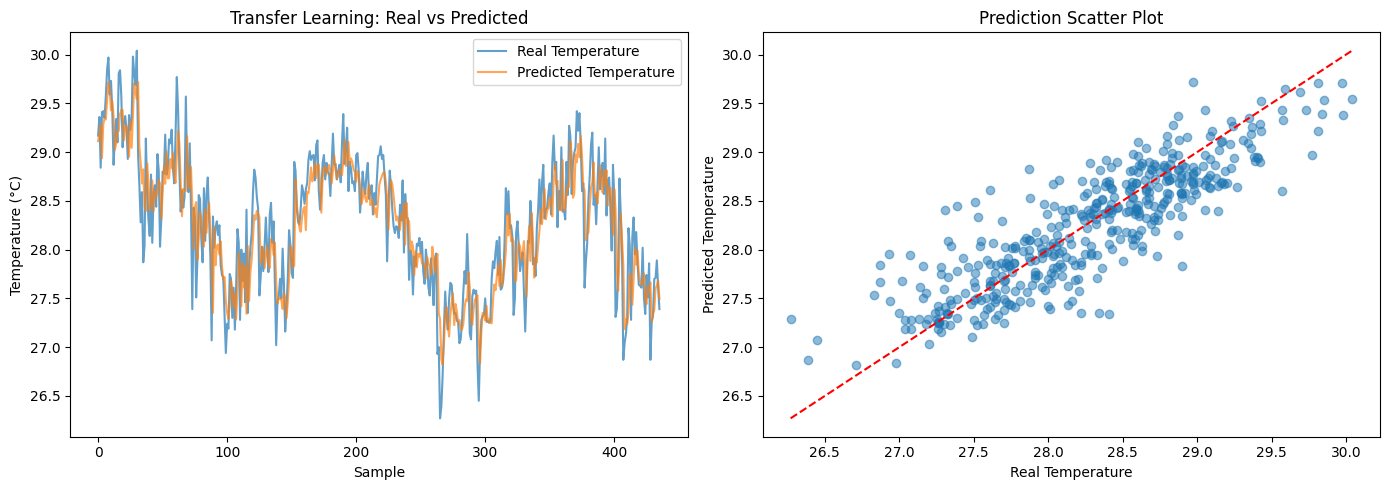

In [19]:
pred_scaled = best_model.predict(X_test_tgt)

def inverse_temp(scaled_temp_array):
    dummy = np.zeros((len(scaled_temp_array), n_features), dtype=float)
    dummy[:,0] = scaled_temp_array
    inv = scaler.inverse_transform(dummy)
    return inv[:,0]

pred_temp = inverse_temp(pred_scaled.flatten())
real_temp = inverse_temp(y_test_tgt.flatten())

mse = mean_squared_error(real_temp, pred_temp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_temp, pred_temp)
mape = np.mean(np.abs((real_temp - pred_temp) / real_temp)) * 100

print("=== Transfer Learning Evaluation (Jakarta) ===")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(real_temp, label='Real Temperature', alpha=0.7)
plt.plot(pred_temp, label='Predicted Temperature', alpha=0.7)
plt.legend(); plt.title("Transfer Learning: Real vs Predicted")
plt.xlabel("Sample"); plt.ylabel("Temperature (°C)")

plt.subplot(1,2,2)
plt.scatter(real_temp, pred_temp, alpha=0.5)
plt.plot([real_temp.min(), real_temp.max()], [real_temp.min(), real_temp.max()], 'r--')
plt.xlabel("Real Temperature"); plt.ylabel("Predicted Temperature")
plt.title("Prediction Scatter Plot")
plt.tight_layout()
plt.show()

In [20]:
encoder_layers = [l for l in best_model.layers if 'lstm_encoder' in l.name][0]
for layer in encoder_layers.layers[-2:]:
    layer.trainable = True

best_model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='mse',
    metrics=['mae']
)

history_unfreeze = best_model.fit(
    X_train_tgt, y_train_tgt,
    validation_split=0.15,
    epochs=20,
    batch_size=32,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

pred_scaled_final = best_model.predict(X_test_tgt)
pred_temp_final = inverse_temp(pred_scaled_final.flatten())
mse_final = mean_squared_error(real_temp, pred_temp_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(real_temp, pred_temp_final)

print("\n=== After Unfreezing Layers ===")
print(f"MSE: {mse_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAE: {mae_final:.4f}")

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0022 - mae: 0.0372 - val_loss: 0.0017 - val_mae: 0.0330
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - mae: 0.0358 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - mae: 0.0379 - val_loss: 0.0017 - val_mae: 0.0331
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - mae: 0.0377 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - mae: 0.0353 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - mae: 0.0354 - val_loss: 0.0017 - val_mae: 0.0331
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - mae: 0.0380 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - mae: 0.0367 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.00

In [21]:
best_model.save("lstm_transfer_final.h5")
best_model.save("lstm_transfer_final.keras")

best_model.export("lstm_model_savedmodel")

print("Models saved:")
print("- lstm_transfer_final.h5")
print("- lstm_transfer_final.keras")
print("- lstm_model_savedmodel/")
print("- scaler.joblib (already saved)")

Saved artifact at 'lstm_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14, 10), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136586821677712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821677904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821679056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821678096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821678288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821680784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821677328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586889111376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821676176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136586821678864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13658682167